In [1]:
import os
import random
import shutil
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from torchvision import transforms

In [ ]:
# Pfad zum Zielordner
combined_dataset_dir = 'organized_dataset'


Gesamtanzahl der Bilder: 49057

Anzahl der Bilder pro Kategorie:
acinonyx jubatus: 438
alopochen aegyptiacus: 7
antidorcas marsupialis: 2824
aves: 102
bos taurus: 11
canis mesomelas: 1044
cn-francolins: 73
cn-other carnivores: 13
cn-owls: 33
cn-raptors: 274
columbidae: 70
corvus albus: 401
corvus capensis: 24
crocuta crocuta: 1045
diceros bicornis: 2198
equus asinus: 34
equus zebra hartmannae: 9122
eupodotis rueppellii: 34
felis catus: 7
felis lybica: 3
galerella sanguinea: 7
genetta genetta: 3
giraffa camelopardalis: 1703
gyps africanus: 3
hyaena brunnea: 4877
hystrix africaeaustralis: 412
lepus capensis: 46
loxodanta africana: 1195
mellivora capensis: 92
neotis ludwigii: 263
numididae: 65
oreotragus oreotragus: 25
oryx gazella: 11961
otocyon megalotis: 22
panthera leo: 1562
panthera pardus: 381
papio anubis: 256
procavia capensis: 76
pronolagus randensis: 112
proteles cristatus: 12
pteroclidae: 1783
raphiceros campestris: 214
struthio camelus: 5440
torgos tracheliotos: 709
tragelaphu

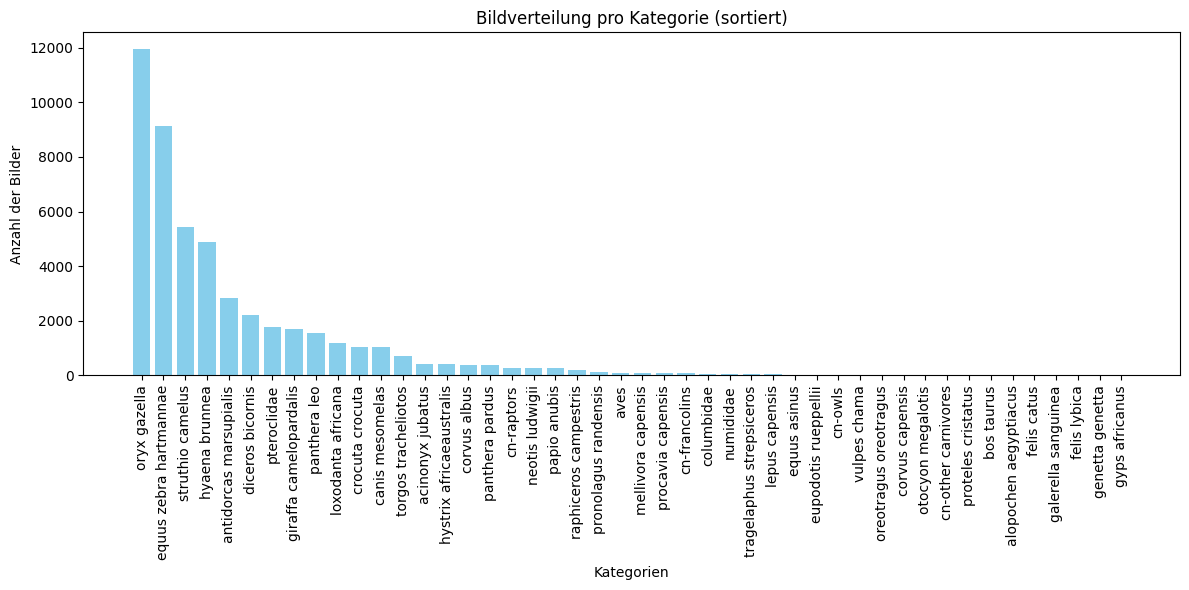

In [3]:
# Gesamtanzahl der Bilder
total_images = 0

# Anzahl der Bilder pro Kategorie
images_per_category = {}

# Iteriere durch jede Kategorie im `combined_dataset`
for category in os.listdir(combined_dataset_dir):
    category_dir = os.path.join(combined_dataset_dir, category)
    
    # Sicherstellen, dass es sich um einen Ordner handelt
    if os.path.isdir(category_dir):
        # Zähle die Bilder in diesem Kategorieordner
        num_images = len([f for f in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, f))])
        
        # Speichere die Anzahl für diese Kategorie
        images_per_category[category] = num_images
        
        # Füge die Anzahl zur Gesamtanzahl hinzu
        total_images += num_images

# Ergebnisse ausgeben
print(f"Gesamtanzahl der Bilder: {total_images}")
print("\nAnzahl der Bilder pro Kategorie:")
for category, count in images_per_category.items():
    print(f"{category}: {count}")

# Kategorien und Werte sortieren
sorted_categories = sorted(images_per_category.items(), key=lambda x: x[1], reverse=True)

# Entpacke die sortierten Kategorien und Bildzahlen
categories, counts = zip(*sorted_categories)

# Histogramm erstellen
plt.figure(figsize=(12, 6))
plt.bar(categories, counts, color='skyblue')
plt.xlabel('Kategorien')
plt.ylabel('Anzahl der Bilder')
plt.title('Bildverteilung pro Kategorie (sortiert)')
plt.xticks(rotation=90)  # Kategorienamen lesbar machen
plt.tight_layout()

# Histogramm anzeigen
plt.show()


In [46]:
# liste der kategorien mit weniger als 20 bildern
categories_with_few_images = [category for category, count in images_per_category.items() if count < 20]
print(f"Kategorien mit weniger als 20 Bildern: {categories_with_few_images}")


Kategorien mit weniger als 20 Bildern: ['alopochen aegyptiacus', 'bos taurus', 'cn-other carnivores', 'felis catus', 'felis lybica', 'galerella sanguinea', 'genetta genetta', 'gyps africanus', 'proteles cristatus']


In [ ]:

# Median der Bildanzahlen
image_counts = np.array(list(images_per_category.values()))
median_count = np.median(image_counts)

print(f"Median der Bildanzahlen pro Kategorie: {median_count}")

# Durchschnitt der Bildanzahlen
mean_count = np.mean(image_counts)

print(f"Durchschnitt der Bildanzahlen pro Kategorie: {mean_count}")

Median der Bildanzahlen pro Kategorie: 97.0
Durchschnitt der Bildanzahlen pro Kategorie: 1066.4565217391305


In [7]:
# anzahl der kategorien mit mehr als 100 bildern

categories_with_many_images = [category for category, count in images_per_category.items() if count > 100]
num_categories_with_many_images = len(categories_with_many_images)

print(f"Anzahl der Kategorien mit mehr als 100 Bildern: {num_categories_with_many_images}")


# Anzahl der kategorien mit mehr als 50 bildern

categories_with_many_images = [category for category, count in images_per_category.items() if count > 50]
num_categories_with_many_images = len(categories_with_many_images)

print(f"Anzahl der Kategorien mit mehr als 50 Bildern: {num_categories_with_many_images}")


# Anzahl der kategorien mit mehr als 30 bildern

categories_with_many_images = [category for category, count in images_per_category.items() if count > 30]
num_categories_with_many_images = len(categories_with_many_images)

print(f"Anzahl der Kategorien mit mehr als 30 Bildern: {num_categories_with_many_images}")



Anzahl der Kategorien mit mehr als 100 Bildern: 23
Anzahl der Kategorien mit mehr als 50 Bildern: 29
Anzahl der Kategorien mit mehr als 30 Bildern: 33


## Optimierung der Datensatz-Balance

- Unterrepräsentierte Kategorien verstärken
- Überrepräsentierte Kategorien reduzieren

In [ ]:

def downsample_and_filter_dataset(input_path, output_path, excluded_path, max_images_per_category, min_images_per_category):
    """
    Führt ein Downsampling durch und lagert Kategorien mit weniger als `min_images_per_category`
    Bildern in einen separaten Ordner aus.

    Args:
    - input_path (str): Pfad zum ursprünglichen Dataset (mit Kategorienordnern).
    - output_path (str): Zielpfad für das balancierte Dataset.
    - excluded_path (str): Zielpfad für ausgelagerte Kategorien.
    - max_images_per_category (int): Maximale Anzahl von Bildern pro Kategorie.
    - min_images_per_category (int): Mindestanzahl von Bildern, um im balancierten Dataset zu bleiben.

    """
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    if not os.path.exists(excluded_path):
        os.makedirs(excluded_path)

    for category in os.listdir(input_path):
        category_path = os.path.join(input_path, category)
        
        if not os.path.isdir(category_path):
            continue
        
        image_files = [
            file for file in os.listdir(category_path) if file.lower().endswith(".jpg")
        ]

        # Wenn die Kategorie zu wenig Bilder hat, in den excluded_path verschieben
        if len(image_files) < min_images_per_category:
            output_category_path = os.path.join(excluded_path, category)
            os.makedirs(output_category_path, exist_ok=True)
            for file in image_files:
                src_path = os.path.join(category_path, file)
                dest_path = os.path.join(output_category_path, file)
                shutil.copy2(src_path, dest_path)
            print(f"Kategorie '{category}' mit {len(image_files)} Bildern ausgelagert.")
        else:
            # Downsampling durchführen
            output_category_path = os.path.join(output_path, category)
            os.makedirs(output_category_path, exist_ok=True)
            
            if len(image_files) > max_images_per_category:
                sampled_files = random.sample(image_files, max_images_per_category)
            else:
                sampled_files = image_files
            
            for file in sampled_files:
                src_path = os.path.join(category_path, file)
                dest_path = os.path.join(output_category_path, file)
                shutil.copy2(src_path, dest_path)
            
            print(f"Kategorie '{category}' mit {len(sampled_files)} Bildern im balancierten Dataset.")

# Pfade und Parameter anpassen
input_dataset = "organized_dataset"          # Original-Dataset
balanced_dataset = "balanced_dataset"        # Pfad für das balancierte Dataset
excluded_dataset = "excluded_dataset"        # Pfad für ausgelagerte Kategorien
max_images = 500                             # Maximale Anzahl von Bildern pro Kategorie
min_images = 20                              # Mindestanzahl von Bildern pro Kategorie



downsample_and_filter_dataset(input_dataset, balanced_dataset, excluded_dataset, max_images, min_images)


Kategorie 'acinonyx jubatus' mit 438 Bildern im balancierten Dataset.
Kategorie 'alopochen aegyptiacus' mit 7 Bildern ausgelagert.
Kategorie 'antidorcas marsupialis' mit 500 Bildern im balancierten Dataset.
Kategorie 'aves' mit 102 Bildern im balancierten Dataset.
Kategorie 'bos taurus' mit 11 Bildern ausgelagert.
Kategorie 'canis mesomelas' mit 500 Bildern im balancierten Dataset.
Kategorie 'cn-francolins' mit 73 Bildern im balancierten Dataset.
Kategorie 'cn-other carnivores' mit 13 Bildern ausgelagert.
Kategorie 'cn-owls' mit 33 Bildern im balancierten Dataset.
Kategorie 'cn-raptors' mit 274 Bildern im balancierten Dataset.
Kategorie 'columbidae' mit 70 Bildern im balancierten Dataset.
Kategorie 'corvus albus' mit 401 Bildern im balancierten Dataset.
Kategorie 'corvus capensis' mit 24 Bildern im balancierten Dataset.
Kategorie 'crocuta crocuta' mit 500 Bildern im balancierten Dataset.
Kategorie 'diceros bicornis' mit 500 Bildern im balancierten Dataset.
Kategorie 'equus asinus' mit 

In [4]:
# anzahl der bilder im balanced dataset
total_images = 0
images_per_category = {}

balanced_dataset = "balanced_dataset"

for category in os.listdir(balanced_dataset):
    category_dir = os.path.join(balanced_dataset, category)
    
    if os.path.isdir(category_dir):
        num_images = len([f for f in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, f))])
        
        images_per_category[category] = num_images
        total_images += num_images


print(f"Gesamtanzahl der Bilder im balancierten Dataset: {total_images}")

print("\nAnzahl der Bilder pro Kategorie:")
for category, count in images_per_category.items():
    print(f"{category}: {count}")

Gesamtanzahl der Bilder im balancierten Dataset: 9993

Anzahl der Bilder pro Kategorie:
acinonyx jubatus: 438
antidorcas marsupialis: 499
aves: 102
canis mesomelas: 500
cn-francolins: 73
cn-owls: 32
cn-raptors: 274
columbidae: 70
corvus albus: 399
corvus capensis: 24
crocuta crocuta: 499
diceros bicornis: 491
equus asinus: 34
equus zebra hartmannae: 496
eupodotis rueppellii: 34
giraffa camelopardalis: 500
hyaena brunnea: 499
hystrix africaeaustralis: 409
lepus capensis: 46
loxodanta africana: 500
mellivora capensis: 91
neotis ludwigii: 263
numididae: 65
oreotragus oreotragus: 25
oryx gazella: 500
otocyon megalotis: 22
panthera leo: 491
panthera pardus: 381
papio anubis: 256
procavia capensis: 76
pronolagus randensis: 112
pteroclidae: 500
raphiceros campestris: 214
struthio camelus: 497
torgos tracheliotos: 500
tragelaphus strepsiceros: 54
vulpes chama: 27


In [ ]:
# Schwellenwert für unterrepräsentierte Kategorien setzen
import numpy as np

threshold = np.median(list(images_per_category.values()))  # Median als Referenzwert
underrepresented_categories = [cat for cat, count in images_per_category.items() if count < threshold]

print(f"\nSchwellenwert für unterrepräsentierte Kategorien: {threshold}")
print("Unterrepräsentierte Kategorien:", underrepresented_categories)


Schwellenwert für unterrepräsentierte Kategorien: 263.0
Unterrepräsentierte Kategorien: ['aves', 'cn-francolins', 'cn-owls', 'columbidae', 'corvus capensis', 'equus asinus', 'eupodotis rueppellii', 'lepus capensis', 'mellivora capensis', 'numididae', 'oreotragus oreotragus', 'otocyon megalotis', 'papio anubis', 'procavia capensis', 'pronolagus randensis', 'raphiceros campestris', 'tragelaphus strepsiceros', 'vulpes chama']


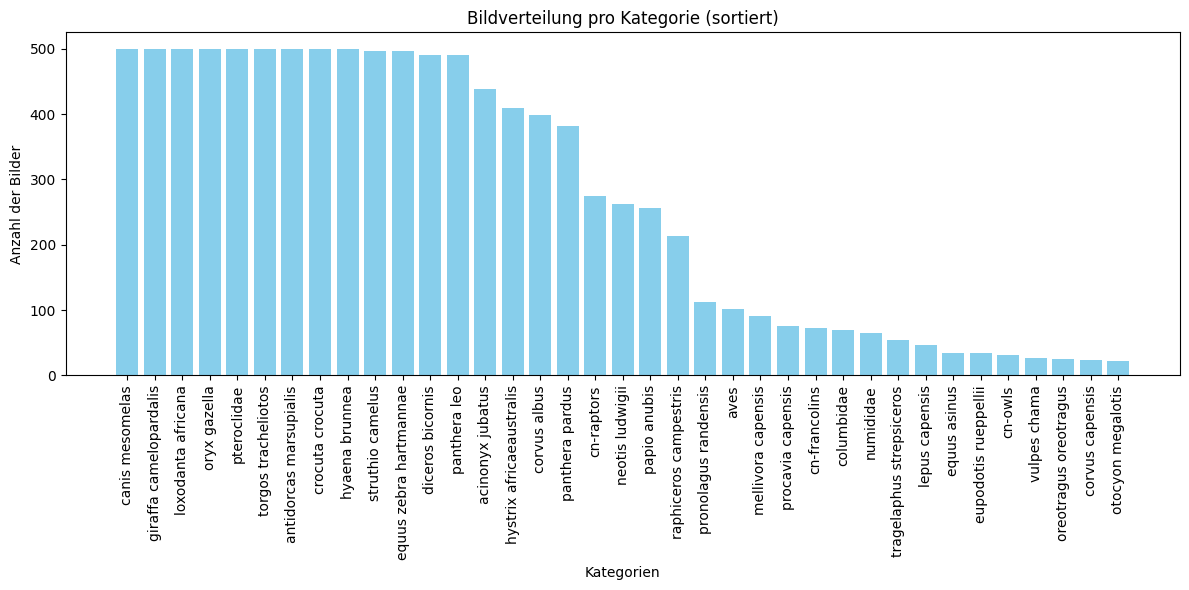

In [5]:

# Kategorien und Werte sortieren
sorted_categories = sorted(images_per_category.items(), key=lambda x: x[1], reverse=True)

# Entpacke die sortierten Kategorien und Bildzahlen
categories, counts = zip(*sorted_categories)

# Histogramm erstellen
plt.figure(figsize=(12, 6))
plt.bar(categories, counts, color='skyblue')
plt.xlabel('Kategorien')
plt.ylabel('Anzahl der Bilder')
plt.title('Bildverteilung pro Kategorie (sortiert)')
plt.xticks(rotation=90)  # Kategorienamen lesbar machen
plt.tight_layout()

# Histogramm anzeigen
plt.show()

### Leere Bilder entfernen
Bilder ohne Tiere drauf entfernen, da man nichts klassifizieren kann

In [3]:
# Lade die JSON-Datei
json_path = "JSONs/desert-lion-camera-traps_detections.json"
with open(json_path, "r") as f:
    data = json.load(f)

# Alle Bilder in der JSON-Datei
all_images = {img["file"] for img in data["images"]}

# Bilder mit Detektionen (wo die "detections"-Liste nicht leer ist)
images_with_detections = {img["file"] for img in data["images"] if img.get("detections")}

# Bilder ohne Detektionen
images_without_detections = all_images - images_with_detections

# Anzahl der Bilder ohne Detektionen
num_images_without_detections = len(images_without_detections)

print(f"Anzahl der Bilder ohne Detektionen: {num_images_without_detections}")

Anzahl der Bilder ohne Detektionen: 192


In [ ]:
balanced_dataset_path = "balanced_dataset"  

# JSON laden
with open(json_path, "r") as f:
    data = json.load(f)

# Umwandlung des JSON-Dateipfads in den balanced_dataset-Format
def convert_filename(json_file_path):
    parts = json_file_path.split("/")
    if len(parts) > 1:
        return f"{parts[0]}_{parts[-1]}"  # Erster Teil + Bildname mit "_"
    return parts[-1]  # Falls kein "/" vorhanden ist, den Originalnamen nutzen

# alle Bildnamen aus der JSON (umgewandelt ins balanced_dataset-Format) extrahieren
all_image_filenames = {convert_filename(img["file"]) for img in data["images"]}

# Bilder mit Detektionen extrahieren
images_with_detections = {
    convert_filename(img["file"]) for img in data["images"] if img.get("detections")
}

# Bilder ohne Detektionen
images_without_detections = all_image_filenames - images_with_detections

# Liste aller Bilder im balanced_dataset
balanced_dataset_images = set()
for root, _, files in os.walk(balanced_dataset_path):  
    for file in files:
        if file.endswith((".jpg", ".png", ".jpeg")):
            balanced_dataset_images.add(file)  # Speichert nur den Dateinamen

# Schnittmenge: Bilder ohne Detektionen, die auch im balanced_dataset existieren
images_without_detections_in_balanced = images_without_detections & balanced_dataset_images


print(f"Anzahl der Bilder ohne Detektionen im balanced_dataset: {len(images_without_detections_in_balanced)}")


Anzahl der Bilder ohne Detektionen im balanced_dataset: 2


In [ ]:
# Ersten 20 extrahierten Bildnamen zur Überprüfung anzeigen
extracted_filenames = list(all_image_filenames)[:20]  
for name in extracted_filenames:
    print(name)

oryx gazella_20110130-PICT4144.JPG
struthio camelus_PICT7904.JPG
giraffa camelopardalis_20140729-PICT0279.JPG
struthio camelus_PICT2643.JPG
hystrix africaeaustralis_PICT0119.JPG
canis mesomelas_20150926-PICT0729.JPG
oryx gazella_20150517-PICT3873.JPG
equus zebra hartmannae_PICT2329.JPG
oryx gazella_20140730-PICT1957.JPG
hyaena brunnea_SUNP1096.JPG
giraffa camelopardalis_PICT0154.JPG
oryx gazella_20150612-PICT4102.JPG
struthio camelus_20141207-PICT0124.JPG
equus zebra hartmannae_20150818-PICT0359.JPG
crocuta crocuta_SUNP0509.JPG
equus zebra hartmannae_20170407-PICT4317.JPG
oryx gazella_PICT0239.JPG
hyaena brunnea_20140130-PICT0102.JPG
struthio camelus_PICT7365.JPG
struthio camelus_PICT0452.JPG


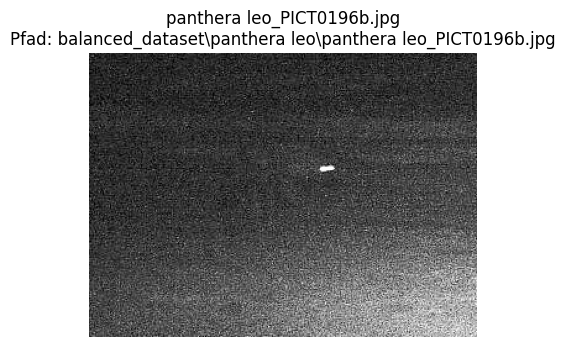

panthera leo_PICT0196b.jpg wurde behalten.


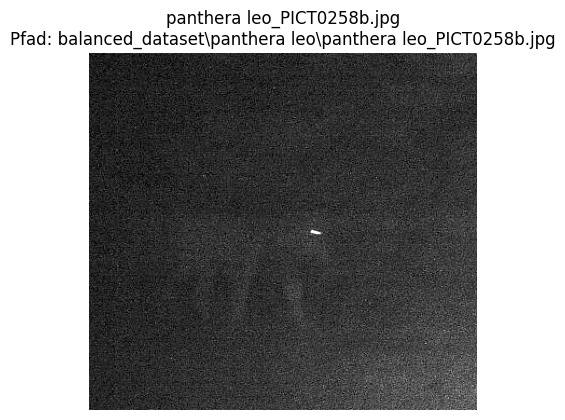

panthera leo_PICT0258b.jpg wurde behalten.


In [ ]:
# ersten 2 Bilder zur manuellen Überprüfung
images_to_check = list(images_without_detections_in_balanced)


# Bilder anzeigen und optional löschen
for img_name in images_to_check:
    img_path = None
    for root, _, files in os.walk(balanced_dataset_path):
        if img_name in files:
            img_path = os.path.join(root, img_name)
            break  

    if img_path and os.path.exists(img_path):
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(5, 5))
            plt.imshow(img)
            plt.title(f"{img_name}\nPfad: {img_path}")
            plt.axis("off")
            plt.show()

            # Benutzer fragen, ob das Bild gelöscht werden soll
            user_input = input(f"Möchtest du {img_name} löschen? (ja/nein): ").strip().lower()
            if user_input == "ja":
                os.remove(img_path)
                print(f"{img_name} wurde gelöscht.")
            else:
                print(f"{img_name} wurde behalten.")
        else:
            print(f"Konnte Bild nicht laden: {img_name}")
    else:
        print(f"Konnte Bildpfad nicht finden: {img_name}")

In [ ]:
# Bilder ohne Bounding Boxen
dataset_path = "balanced_dataset"  

# Maximale Größe für die Anzeige
MAX_WIDTH = 800
MAX_HEIGHT = 800

# Interaktive Bildprüfung
for img_file in images_without_bboxes:
    img_path = os.path.join(dataset_path, img_file)

    if not os.path.exists(img_path): 
        print(f"Bild nicht gefunden: {img_path}")
        continue

    img = cv2.imread(img_path)

    # Bildgröße anpassen, falls zu groß
    height, width = img.shape[:2]
    scale = min(MAX_WIDTH / width, MAX_HEIGHT / height, 1.0)  

    if scale < 1.0:  # Falls das Bild größer als MAX_WIDTH oder MAX_HEIGHT ist
        new_size = (int(width * scale), int(height * scale))
        img = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)

    # Zeige das Bild
    cv2.imshow("Bild ohne Bounding Box - (b = Behalten, d = Löschen, q = Beenden)", img)

    while True:
        key = cv2.waitKey(0) & 0xFF  

        if key == ord("b"):  # Bild behalten
            print(f"Behalten: {img_file}")
            break
        elif key == ord("d"):  # Bild löschen
            os.remove(img_path)
            print(f"Gelöscht: {img_file}")
            break
        elif key == ord("q"):  # Beenden
            print("Manuelle Überprüfung abgebrochen.")
            cv2.destroyAllWindows()
            exit()

cv2.destroyAllWindows()